#Setup

In [1]:
from os.path import join
import os
import re

from google.colab import drive

import numpy as np

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2


device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/인지프/PLSU_4064_flip_rotate.zip" -d "/content/"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/PLSU_4064_flip_rotate/Mask/mask2512.jpg  
  inflating: /content/__MACOSX/PLSU_4064_flip_rotate/Mask/._mask2512.jpg  
  inflating: /content/PLSU_4064_flip_rotate/Mask/mask255.jpg  
  inflating: /content/__MACOSX/PLSU_4064_flip_rotate/Mask/._mask255.jpg  
  inflating: /content/PLSU_4064_flip_rotate/Mask/mask533.jpg  
  inflating: /content/__MACOSX/PLSU_4064_flip_rotate/Mask/._mask533.jpg  
  inflating: /content/PLSU_4064_flip_rotate/Mask/mask2274.jpg  
  inflating: /content/__MACOSX/PLSU_4064_flip_rotate/Mask/._mask2274.jpg  
  inflating: /content/PLSU_4064_flip_rotate/Mask/mask3181.jpg  
  inflating: /content/__MACOSX/PLSU_4064_flip_rotate/Mask/._mask3181.jpg  
  inflating: /content/PLSU_4064_flip_rotate/Mask/mask1796.jpg  
  inflating: /content/__MACOSX/PLSU_4064_flip_rotate/Mask/._mask1796.jpg  
  inflating: /content/PLSU_4064_flip_rotate/Mask/mask1782.jpg  
  inflating: /content/__MACOSX/PLSU_4064_flip_rotate/Mask/._mask1782.j

# Sorting Data

In [2]:
## 파일 이름에서 숫자 부분을 추출하는 함수
def extract_number(file_name):
    numbers = re.findall(r'\d+', file_name)
    return int(numbers[0]) if numbers else 0


def list_files_in_directory(directory_path):
    items_in_directory = sorted(os.listdir(directory_path))
    files_in_directory = [item for item in items_in_directory if os.path.isfile(os.path.join(directory_path, item))]

    return files_in_directory

In [3]:
# 이미지와 마스크 파일 경로 가져오기 및 정렬
mask_directory = '/content/PLSU_4064_flip_rotate/Mask'
mask_files = list_files_in_directory(mask_directory)
sorted_mask_files = sorted(mask_files, key=extract_number)
print(sorted_mask_files)
print(len(sorted_mask_files))



image_directory = '/content/PLSU_4064_flip_rotate/img'
image_files = list_files_in_directory(image_directory)
sorted_image_files = sorted(image_files, key=extract_number)
print(sorted_image_files)
print(len(sorted_image_files))



# 이미지와 마스크 파일의 전체 경로 생성
image_paths = [os.path.join(image_directory, file_name) for file_name in sorted_image_files]
mask_paths = [os.path.join(mask_directory, file_name) for file_name in sorted_mask_files]



# 이미지와 마스크의 경로 예시를 보고 혹시 파일 리스트가 순서대로 정렬되어 있지 않는지 확인해봅니다.
print(f'이미지 경로 예시 : {image_paths[:5]}')
print(f'마스크 경로 예시 : {mask_paths[:5]}')

['mask1.jpg', 'mask2.jpg', 'mask3.jpg', 'mask4.jpg', 'mask5.jpg', 'mask6.jpg', 'mask7.jpg', 'mask8.jpg', 'mask9.jpg', 'mask10.jpg', 'mask11.jpg', 'mask12.jpg', 'mask13.jpg', 'mask14.jpg', 'mask15.jpg', 'mask16.jpg', 'mask17.jpg', 'mask18.jpg', 'mask19.jpg', 'mask20.jpg', 'mask21.jpg', 'mask22.jpg', 'mask23.jpg', 'mask24.jpg', 'mask25.jpg', 'mask26.jpg', 'mask27.jpg', 'mask28.jpg', 'mask29.jpg', 'mask30.jpg', 'mask31.jpg', 'mask32.jpg', 'mask33.jpg', 'mask34.jpg', 'mask35.jpg', 'mask36.jpg', 'mask37.jpg', 'mask38.jpg', 'mask39.jpg', 'mask40.jpg', 'mask41.jpg', 'mask42.jpg', 'mask43.jpg', 'mask44.jpg', 'mask45.jpg', 'mask46.jpg', 'mask47.jpg', 'mask48.jpg', 'mask49.jpg', 'mask50.jpg', 'mask51.jpg', 'mask52.jpg', 'mask53.jpg', 'mask54.jpg', 'mask55.jpg', 'mask56.jpg', 'mask57.jpg', 'mask58.jpg', 'mask59.jpg', 'mask60.jpg', 'mask61.jpg', 'mask62.jpg', 'mask63.jpg', 'mask64.jpg', 'mask65.jpg', 'mask66.jpg', 'mask67.jpg', 'mask68.jpg', 'mask69.jpg', 'mask70.jpg', 'mask71.jpg', 'mask72.jpg', 

# Custom Dataset

In [ ]:
#No augmentation, test시 이미지만 반환하도록 하는 코드
# class PalmDataset(Dataset):
#     def __init__(self, image_paths, mask_paths, size=(256, 256), mode='train'):
#         self.image_paths = image_paths
#         self.mask_paths = mask_paths
#         self.resize = size
#         self.mode = mode

#         # 기본 변환: 모든 모드에 적용
#         base_transform = [
#             A.Resize(*size),
#             A.Normalize(),
#             ToTensorV2()
#         ]

#         # Train 모드에만 적용될 추가적인 데이터 증강 변환
#         if mode == 'train':
#             self.transform = A.Compose([
#                 # data augmentation 적는 곳
#             ] + base_transform)
#         else:
#             # Validation 및 Test 모드에서는 기본 변환만 적용
#             self.transform = A.Compose(base_transform)

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         image = cv2.imread(self.image_paths[idx])
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         if self.mode in ['train', 'val']:
#             mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
#             mask = mask / 255
#             augmented = self.transform(image=image, mask=mask)
#             return augmented['image'], augmented['mask']
#         else:
#             # 테스트 모드에서는 마스크 없이 이미지만 반환
#             return self.transform(image=image)['image']

In [4]:
from torch.utils.data import Dataset
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

class PalmDataset(Dataset):
    def __init__(self, image_paths, mask_paths, size=(256, 256), mode='train'):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.resize = size
        self.mode = mode

        # 기본 변환: 모든 모드에 적용
        base_transform = [
            A.Resize(*size),
            A.Normalize(),
            ToTensorV2()
        ]

        transform = [
            A.Resize(*size),
            ToTensorV2()
        ]
        self.normal_transform = A.Compose(transform)

        # Train 모드에만 적용될 추가적인 데이터 증강 변환
        if mode == 'train':
            self.transform = A.Compose([
                # data augmentation 적는 곳
            ] + base_transform)
        else:
            # Validation 및 Test 모드에서는 기본 변환만 적용
            self.transform = A.Compose(base_transform)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = mask / 255  # Normalize the mask to be [0, 1]

        # 변환 적용
        augmented = self.transform(image=image, mask=mask)
        augmented2 = self.normal_transform(image=image, mask=mask)
        return augmented['image'], augmented['mask'] , augmented2['image']


# Data Lodaer

In [5]:
#train:val:test = 75%:15%:15%
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.3, random_state=42)
test_image_paths, val_image_paths, test_mask_paths, val_mask_paths = train_test_split(test_image_paths, test_mask_paths, test_size=0.5, random_state=42)

train_dataset = PalmDataset(train_image_paths, train_mask_paths, size=(256,256),mode='train')
val_dataset = PalmDataset(val_image_paths, val_mask_paths, size=(256,256),mode='val')
test_dataset = PalmDataset(test_image_paths, test_mask_paths, size=(256,256),mode='test')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# 첫 번째 배치 가져오기
images, masks, images_ = next(iter(train_loader))

# 이미지와 마스크 시각화
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))
for i in range(4):
    ax[i, 0].imshow(images_[i].permute(1, 2, 0))  # 이미지
    ax[i, 1].imshow(masks[i], cmap='gray')  # 마스크
    ax[i, 0].set_title("Image")
    ax[i, 1].set_title("Mask")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

plt.tight_layout()
plt.show()

ValueError: ignored

# Define Model

In [6]:
resnet = torchvision.models.resnet.resnet50(pretrained=True)

class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x


class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """

        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


class UNetWithResnet50Encoder(nn.Module):
    DEPTH = 6

    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()
        resnet = torchvision.models.resnet.resnet50(pretrained=True)
        down_blocks = []
        up_blocks = []

        # 입력 채널을 n_channels로 조정
        self.input_block = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            *list(resnet.children())[1:3]
        )
        self.input_pool = list(resnet.children())[3]

        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        up_blocks.append(UpBlockForUNetWithResNet50(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet50(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet50(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (UNetWithResnet50Encoder.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UNetWithResnet50Encoder.DEPTH - 1 - i}"
            x = block(x, pre_pools[key])
        output_feature_map = x
        x = self.out(x)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 150MB/s]


#Evaluate

In [7]:
# F-1 Score와 IoU 계산을 위한 함수
def calculate_f1_score(preds, labels):
    # 시그모이드 함수를 적용하여 확률로 변환
    preds = torch.sigmoid(preds)
    # 확률을 이진화 (0.5를 임계값으로 사용)
    preds = (preds > 0.5).float()

    # True Positives, False Positives, False Negatives 계산
    tp = (preds * labels).sum(dim=[1, 2, 3])
    fp = (preds * (1 - labels)).sum(dim=[1, 2, 3])
    fn = ((1 - preds) * labels).sum(dim=[1, 2, 3])

    # F1 Score 계산
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

    # 배치 내 모든 이미지에 대한 F1 Score의 평균 반환
    return f1.mean().item()

def calculate_iou(preds, labels):
    # 시그모이드 함수를 적용하여 확률로 변환
    preds = torch.sigmoid(preds)
    # 확률을 이진화 (0.5를 임계값으로 사용)
    preds = (preds > 0.5).float()

    # True Positives, False Positives, False Negatives 계산
    intersection = (preds * labels).sum(dim=[1, 2, 3])  # 교집합
    total = (preds + labels).sum(dim=[1, 2, 3])  # 합집합
    union = total - intersection  # 합집합 - 교집합

    # IoU 계산
    iou = (intersection + 1e-6) / (union + 1e-6)  # 0으로 나누는 것을 방지하기 위한 작은 값 추가

    # 배치 내 모든 이미지에 대한 IoU의 평균 반환
    return iou.mean().item()


# Loss function

In [8]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # inputs : 모델 출력, targets : 실제 마스크
        inputs = torch.sigmoid(inputs)  # 시그모이드 함수를 적용하여 확률로 변환

        # 평탄화
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Dice 계수 계산
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + self.smooth)/(inputs.sum() + targets.sum() + self.smooth)

        # Dice 손실
        return 1 - dice

#Train

In [9]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch

        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


Epoch 1, Loss: 0.8973916005552485, Validation Loss: 0.7631588995456695, Avg F-1: 0.505239337682724, mIoU: 0.3413329988718033


100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


Epoch 2, Loss: 0.7865768738007277, Validation Loss: 0.9761771708726883, Avg F-1: 0.016008666530251504, mIoU: 0.008754988383891238


100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


Epoch 3, Loss: 0.697539167457752, Validation Loss: 0.7044008433818817, Avg F-1: 0.2977582350373268, mIoU: 0.17705490067601204


100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


Epoch 4, Loss: 0.5748726196503371, Validation Loss: 0.6102406114339829, Avg F-1: 0.37935141026973723, mIoU: 0.24084208756685258


100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


Epoch 5, Loss: 0.4252521415774742, Validation Loss: 0.4155629277229309, Avg F-1: 0.5835381418466568, mIoU: 0.4160913586616516


100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


Epoch 6, Loss: 0.35572423827782107, Validation Loss: 0.35550991594791415, Avg F-1: 0.6413672566413879, mIoU: 0.4759522631764412


100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


Epoch 7, Loss: 0.32546228036451874, Validation Loss: 0.3161423295736313, Avg F-1: 0.6802172154188156, mIoU: 0.5187692329287529


100%|██████████| 20/20 [00:22<00:00,  1.10s/it]


Epoch 8, Loss: 0.3083430347817667, Validation Loss: 0.32170545160770414, Avg F-1: 0.6746441185474396, mIoU: 0.5132687017321587


100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


Epoch 9, Loss: 0.29687563154134855, Validation Loss: 0.2984418570995331, Avg F-1: 0.6984818369150162, mIoU: 0.5400391936302185


100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


Epoch 10, Loss: 0.2901409509476651, Validation Loss: 0.29378947615623474, Avg F-1: 0.7037645667791367, mIoU: 0.5458054006099701


100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


Epoch 11, Loss: 0.28475119826498996, Validation Loss: 0.28796355724334716, Avg F-1: 0.7088404655456543, mIoU: 0.5521266281604766


100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


Epoch 12, Loss: 0.2964526629180051, Validation Loss: 0.30992190837860106, Avg F-1: 0.6860539585351944, mIoU: 0.5271082878112793


100%|██████████| 20/20 [00:20<00:00,  1.04s/it]


Epoch 13, Loss: 0.2897733985708001, Validation Loss: 0.2921929657459259, Avg F-1: 0.7053336799144745, mIoU: 0.5477212846279145


100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


Epoch 14, Loss: 0.287030669410577, Validation Loss: 0.29937190413475034, Avg F-1: 0.6975019782781601, mIoU: 0.5388264745473862


100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


Epoch 15, Loss: 0.28154190403691837, Validation Loss: 0.28475346565246584, Avg F-1: 0.7118627667427063, mIoU: 0.5558486312627793


100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


Epoch 16, Loss: 0.2767999071753427, Validation Loss: 0.2894641488790512, Avg F-1: 0.7074208170175552, mIoU: 0.5502509623765945


100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Epoch 17, Loss: 0.27299230755045173, Validation Loss: 0.27772676944732666, Avg F-1: 0.719213604927063, mIoU: 0.5645116925239563


100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Epoch 18, Loss: 0.26934490846783926, Validation Loss: 0.2801043212413788, Avg F-1: 0.7166941940784455, mIoU: 0.5615724325180054


100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


Epoch 19, Loss: 0.2659305434548453, Validation Loss: 0.2734451502561569, Avg F-1: 0.7236120969057083, mIoU: 0.5696177512407303


100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


Epoch 20, Loss: 0.2627719587154603, Validation Loss: 0.26912130117416383, Avg F-1: 0.7281505584716796, mIoU: 0.5753220409154892


100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


Epoch 21, Loss: 0.26077595922384367, Validation Loss: 0.2704255700111389, Avg F-1: 0.7268909454345703, mIoU: 0.5737590610980987


100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


Epoch 22, Loss: 0.26628361860018096, Validation Loss: 0.273167222738266, Avg F-1: 0.7241506159305573, mIoU: 0.5703401237726211


100%|██████████| 20/20 [00:21<00:00,  1.05s/it]


Epoch 23, Loss: 0.2651051122151064, Validation Loss: 0.2754232197999954, Avg F-1: 0.721736803650856, mIoU: 0.5675141662359238


100%|██████████| 20/20 [00:21<00:00,  1.05s/it]


Epoch 24, Loss: 0.26293506515160037, Validation Loss: 0.27615484297275544, Avg F-1: 0.7211585521697998, mIoU: 0.5669429033994675


100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


Epoch 25, Loss: 0.26216521490825695, Validation Loss: 0.2727306544780731, Avg F-1: 0.7240562319755555, mIoU: 0.570403590798378


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Epoch 26, Loss: 0.2594926343874985, Validation Loss: 0.2707348197698593, Avg F-1: 0.7265434682369232, mIoU: 0.5733626693487167


100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


Epoch 27, Loss: 0.25686982977256345, Validation Loss: 0.2674939692020416, Avg F-1: 0.7297567903995514, mIoU: 0.5772488355636597


100%|██████████| 20/20 [00:19<00:00,  1.00it/s]


Epoch 28, Loss: 0.25463644172368427, Validation Loss: 0.2667271256446838, Avg F-1: 0.7299326688051224, mIoU: 0.5776597112417221


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Epoch 29, Loss: 0.2522511281324237, Validation Loss: 0.26535615921020506, Avg F-1: 0.7320359081029892, mIoU: 0.5799401611089706


100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


Epoch 30, Loss: 0.2509787276889501, Validation Loss: 0.2652526259422302, Avg F-1: 0.732123601436615, mIoU: 0.5801353007555008


100%|██████████| 20/20 [00:20<00:00,  1.04s/it]


Epoch 31, Loss: 0.2493447500668215, Validation Loss: 0.2645636051893234, Avg F-1: 0.7328062683343888, mIoU: 0.58105688393116


100%|██████████| 20/20 [00:20<00:00,  1.04s/it]


Epoch 32, Loss: 0.24925573287385233, Validation Loss: 0.26548624932765963, Avg F-1: 0.7315009832382202, mIoU: 0.5794590502977371


100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


Epoch 33, Loss: 0.2492437670739849, Validation Loss: 0.2646868109703064, Avg F-1: 0.7326845437288284, mIoU: 0.5806486368179321


100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


Epoch 34, Loss: 0.24890602371665868, Validation Loss: 0.26525987684726715, Avg F-1: 0.7316253483295441, mIoU: 0.5794561982154847


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Epoch 35, Loss: 0.2476444003287326, Validation Loss: 0.26561489701271057, Avg F-1: 0.7315237939357757, mIoU: 0.579506117105484


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Epoch 36, Loss: 0.24597101599982615, Validation Loss: 0.26526371836662294, Avg F-1: 0.7317703574895859, mIoU: 0.5797439157962799


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Epoch 37, Loss: 0.2446755338250921, Validation Loss: 0.2640990227460861, Avg F-1: 0.7328861296176911, mIoU: 0.5812254399061203


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Epoch 38, Loss: 0.24425330724609032, Validation Loss: 0.2633752703666687, Avg F-1: 0.7338098078966141, mIoU: 0.5821975082159042


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Epoch 39, Loss: 0.24264035867841055, Validation Loss: 0.26271874010562896, Avg F-1: 0.7346421718597412, mIoU: 0.5832786113023758


100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Epoch 40, Loss: 0.24125868952676152, Validation Loss: 0.26347741186618806, Avg F-1: 0.7335601866245269, mIoU: 0.5819519430398941


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Epoch 41, Loss: 0.24073486314730697, Validation Loss: 0.26269626021385195, Avg F-1: 0.7347147256135941, mIoU: 0.5834314078092575


100%|██████████| 20/20 [00:20<00:00,  1.04s/it]


Epoch 42, Loss: 0.23778884531406874, Validation Loss: 0.26184223890304564, Avg F-1: 0.7355222851037979, mIoU: 0.5843449503183364


100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


Epoch 43, Loss: 0.23599275712216838, Validation Loss: 0.26111950874328616, Avg F-1: 0.7364630788564682, mIoU: 0.5855074495077133


100%|██████████| 20/20 [00:20<00:00,  1.04s/it]


Epoch 44, Loss: 0.23605988400705744, Validation Loss: 0.2619620621204376, Avg F-1: 0.7354557007551193, mIoU: 0.5843171954154969


100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


Epoch 45, Loss: 0.23578251814574339, Validation Loss: 0.2621337354183197, Avg F-1: 0.7348088622093201, mIoU: 0.5835568994283676


100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Epoch 46, Loss: 0.2348708590764678, Validation Loss: 0.2624328374862671, Avg F-1: 0.7349358111619949, mIoU: 0.5836266070604325


100%|██████████| 20/20 [00:19<00:00,  1.00it/s]


Epoch 47, Loss: 0.23507761821318207, Validation Loss: 0.26231911182403567, Avg F-1: 0.7354542255401612, mIoU: 0.5841525614261627


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Epoch 48, Loss: 0.23435183455435077, Validation Loss: 0.26193429827690123, Avg F-1: 0.7354521512985229, mIoU: 0.584273275732994


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Epoch 49, Loss: 0.2346163767107417, Validation Loss: 0.2640080779790878, Avg F-1: 0.7331311374902725, mIoU: 0.5815177857875824


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Epoch 50, Loss: 0.2342725262213289, Validation Loss: 0.2630914688110352, Avg F-1: 0.7343540757894516, mIoU: 0.5830243796110153


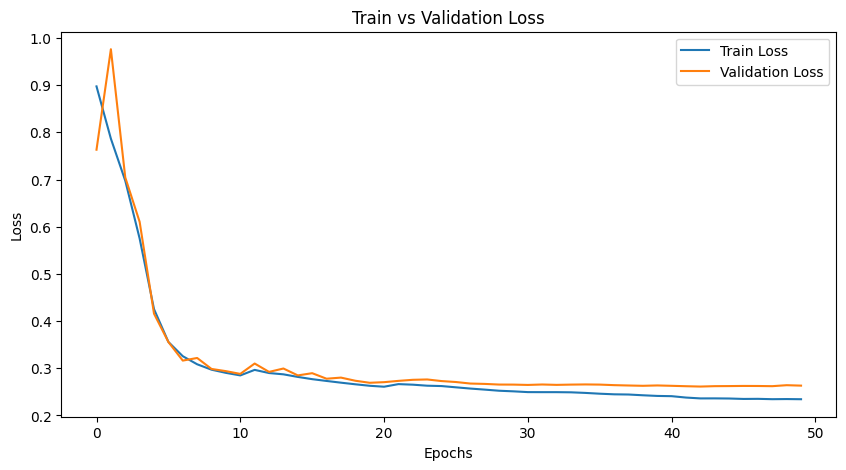

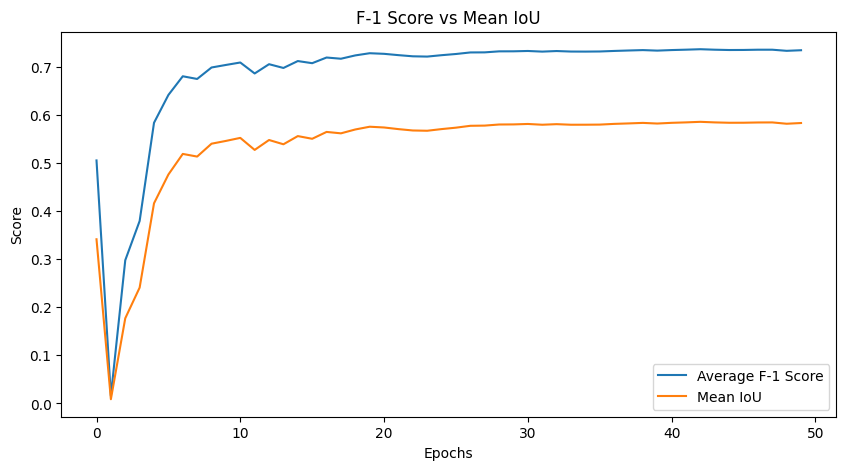

In [ ]:
import matplotlib.pyplot as plt

# 성능 기록을 위한 리스트 초기화
train_losses = []
val_losses = []
f1_scores_epochs = []
iou_scores_epochs = []



#하이퍼 파라미터
num_epochs = 50
learning_rate = 0.001
T_max = 50  # 학습률 주기

# 최상의 모델을 저장하기 위한 초기 설정
best_iou_score = 0.0
early_stopping_counter = 0
patience = 10  # 성능이 개선되지 않는 에포크 한계값

# model 초기화
model = UNetWithResnet50Encoder(n_channels=3, n_classes=1).to(device)
model = model.to(device)

#loss function과 optimizer 정리
criterion = DiceLoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4, amsgrad=False)

# CosineAnnealingLR 스케줄러 초기화
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=10, T_mult=1, eta_max=0.01,  T_up=1, gamma=0.5)

# training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(train_loader):
        images = images.float().to(device)
        masks = masks.float().to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    #Learning Rate 조정
    scheduler.step()

    train_losses.append(epoch_loss / len(train_loader))

    # Validation loop
    model.eval()
    val_loss = 0
    iou_scores = []
    f1_scores = []
    with torch.no_grad():
        for images, masks in tqdm(val_loader):  # val_loader는 검증 데이터셋에 대한 DataLoader입니다.
            images = images.float().to(device)
            masks = masks.float().to(device).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # F-1 Score와 IoU 계산
            f1 = calculate_f1_score(outputs, masks)
            iou = calculate_iou(outputs, masks)
            f1_scores.append(f1)
            iou_scores.append(iou)

    # 평균 IoU 및 손실 계산
    val_loss /= len(val_loader)
    avg_f1 = np.mean(f1_scores)
    avg_iou = np.mean(iou_scores)
    val_losses.append(val_loss)
    f1_scores_epochs.append(avg_f1)
    iou_scores_epochs.append(avg_iou)


    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader)}, Validation Loss: {val_loss}, Avg F-1: {avg_f1}, mIoU: {avg_iou}')

    # Early Stopping
    if avg_iou > best_iou_score:
        best_iou_score = avg_iou
        early_stopping_counter = 0
        # 가장 좋은 모델 저장
        torch.save(model.state_dict(), '/content/drive/MyDrive/인지프/checkpoints/best_model_CustomCosinAnnealingLR.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered")
            break

# 학습 및 검증 손실 그래프
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

# F-1 Score와 mIoU Score 그래프
plt.figure(figsize=(10, 5))
plt.plot(f1_scores_epochs, label='Average F-1 Score')
plt.plot(iou_scores_epochs, label='Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('F-1 Score vs Mean IoU')
plt.legend()
plt.show()

#Test

In [11]:
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from PIL import Image

In [13]:
model = UNetWithResnet50Encoder(n_channels=3, n_classes=1).to(device)
model = model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/인지프/checkpoints/best_model_CustomCosinAnnealingLR.pth'))

<All keys matched successfully>

In [14]:
#evaluate Test
# 모델을 평가 모드로 설정
model.eval()

# 점수 초기화
total_f1_score = 0.0
total_iou_score = 0.0
num_samples = 0

# 테스트 데이터셋에 대한 루프
for images, masks, _ in test_loader:
    with torch.no_grad():
        # 데이터를 장치에 로드
        images = images.float().to(device)
        masks = masks.float().to(device).unsqueeze(1)

        # 모델 예측
        outputs = model(images)

        # F1 점수와 IoU 점수 계산
        f1 = calculate_f1_score(outputs, masks)
        iou = calculate_iou(outputs, masks)
        total_f1_score += f1
        total_iou_score += iou
        num_samples += 1

# 평균 F1 점수와 IoU 점수 출력
avg_f1_score = total_f1_score / num_samples
avg_iou_score = total_iou_score / num_samples
print(f"Average F1 Score on Test Set: {avg_f1_score}")
print(f"Average IoU Score on Test Set: {avg_iou_score}")

Average F1 Score on Test Set: 0.7309690237045288
Average IoU Score on Test Set: 0.5787610143423081


#Test 1 | f1: 0.7281039357185364, iou: 0.575221061706543


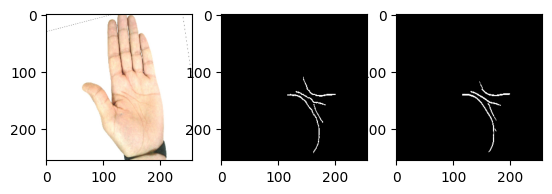

#Test 2 | f1: 0.7238823175430298, iou: 0.5697993636131287


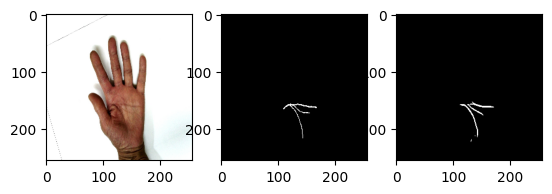

#Test 3 | f1: 0.7384076118469238, iou: 0.5881320238113403


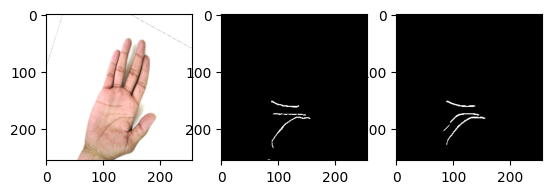

#Test 4 | f1: 0.7290939092636108, iou: 0.5773565769195557


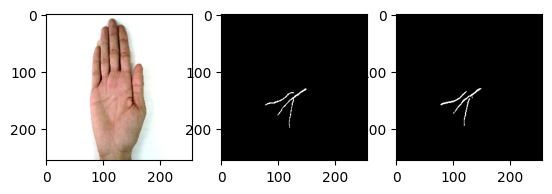

#Test 5 | f1: 0.7437824010848999, iou: 0.5943002700805664


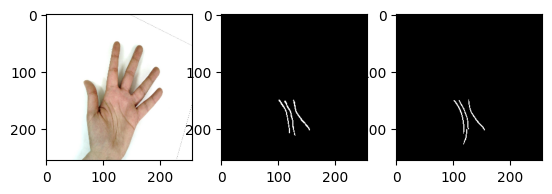

#Test 6 | f1: 0.7256531715393066, iou: 0.5714905261993408


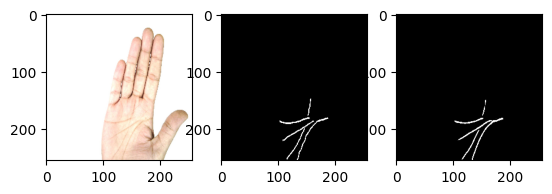

#Test 7 | f1: 0.7323510646820068, iou: 0.5818110108375549


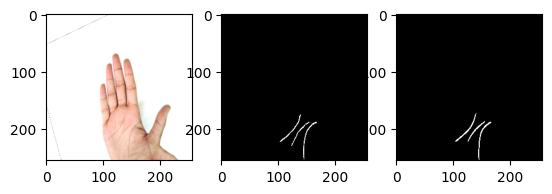

#Test 8 | f1: 0.7410918474197388, iou: 0.5905823111534119


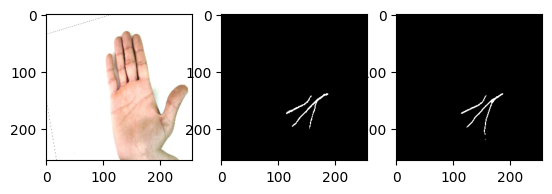

#Test 9 | f1: 0.7279788255691528, iou: 0.574721097946167


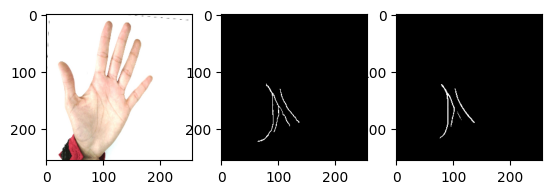

#Test 10 | f1: 0.7316962480545044, iou: 0.5804988145828247


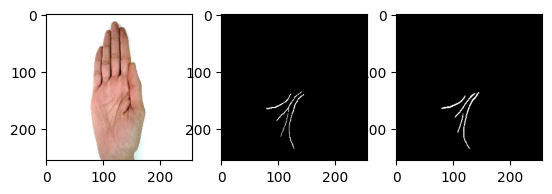

In [15]:
#Print Test Mask
model.eval()

k = 1
f1_scores = []
iou_scores = []
for images, masks, real in test_loader:
    if k > 10:
        break
    with torch.no_grad():
        images = images.float().to(device)
        masks = masks.float().to(device).unsqueeze(1)
        outputs = model(images)

        # F1와 IoU 계산
        f1 = calculate_f1_score(outputs, masks)
        iou = calculate_iou(outputs, masks)
        f1_scores.append(f1)
        iou_scores.append(iou)

        print(f"#Test {k} | f1: {f1}, iou: {iou}")

        # 시각화
        img_cpu = real[0].cpu().numpy().transpose(1, 2, 0)  # 첫 번째 이미지 선택
        mask_cpu = masks[0].squeeze().cpu().numpy()           # 첫 번째 마스크 선택
        output_sigmoid = torch.sigmoid(outputs[0]).squeeze().cpu().numpy()  # 첫 번째 출력 선택, 채널 차원 제거
        plt.subplot(1, 3, 1)
        plt.imshow(img_cpu)
        plt.subplot(1, 3, 2)
        plt.imshow(mask_cpu, cmap='gray')
        plt.subplot(1, 3, 3)
        plt.imshow(output_sigmoid, cmap='gray')
        plt.show()
        k += 1

#Experiments

In [ ]:
pip install pyheif

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 41.4 MB/s eta 0:00:00


In [ ]:
import pyheif

In [ ]:
def heic_to_jpeg(heic_dir, jpeg_dir):

    heif_file = pyheif.read(heic_dir)

    image = Image.frombytes(
        heif_file.mode,
        heif_file.size,
        heif_file.data,
        "raw",
        heif_file.mode,
        heif_file.stride
        )

    print(heif_file)
    image.save(jpeg_dir,"JPEG")

In [ ]:
heic_to_jpeg("./inputs/IMG_6732.HEIC", "./inputs/IMG_6732.jpg")

<HeifFile 4032x3024 RGB with 36578304 bytes data>


In [ ]:
# 단일 이미지에 대한 전처리 및 데이터 증강을 수행하는 함수
def preprocess_image(img_path, size=(256, 256)):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 데이터 증강 및 전처리 파이프라인
    transform = A.Compose([
        A.Resize(*size),
        A.Normalize(),
        ToTensorV2()
    ])

    # 변환 적용
    transformed = transform(image=image)
    return transformed['image']

In [ ]:
# 단일 이미지를 검출하는 함수
def detect(jpeg_dir, model, device, save=True):
    # 이미지 전처리
    image = preprocess_image(jpeg_dir)

    # 모델 예측
    with torch.no_grad():
        image = image.float().unsqueeze(0).to(device)
        outputs = model(image)

    # 시각화
    pil_img = Image.open(jpeg_dir).convert('RGB').resize((256, 256), resample=Image.NEAREST)
    img_cpu = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    output_sigmoid = torch.sigmoid(outputs).squeeze(0).cpu().numpy().squeeze()  # 첫 번째 차원 제거

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(pil_img)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(output_sigmoid, cmap='gray')  # 2차원 배열
    plt.title('Predicted Mask')
    plt.show()

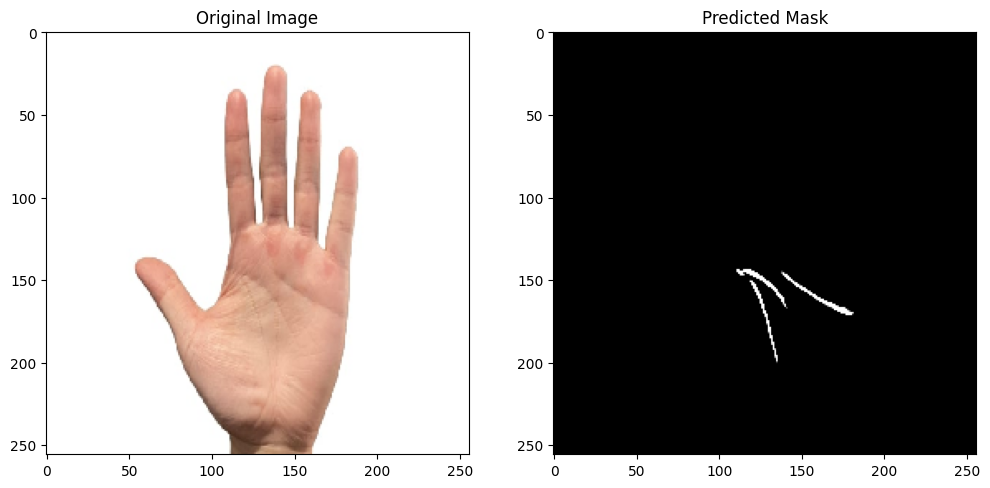

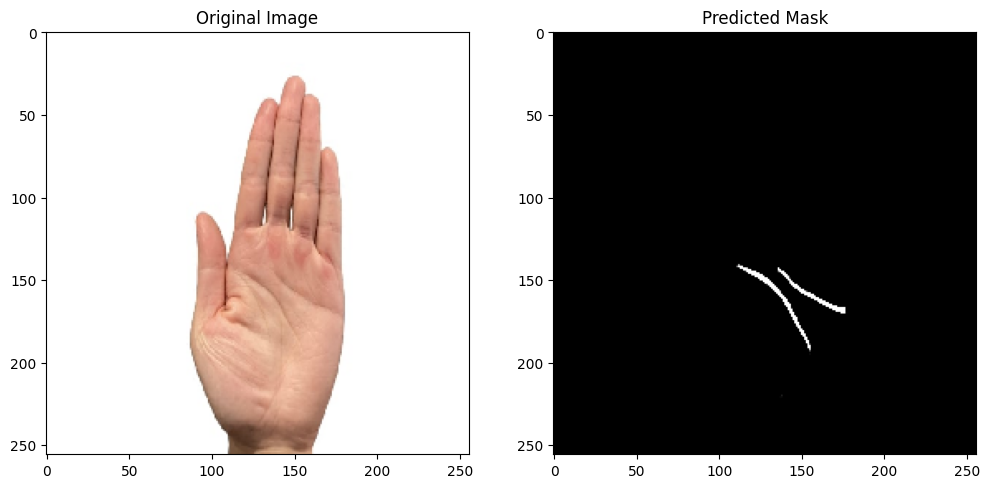

In [ ]:
detect("/content/hand1_1.jpg",model,device)
detect("/content/hand1_2.jpg",model,device)

In [ ]:
detect("./inputs/hand2_1.jpeg")
detect("./inputs/hand2_2.jpeg")
detect("./inputs/hand2_3.jpg")
detect("./inputs/hand2_4.jpg")

In [ ]:
detect("./inputs/hand4_1.jpeg")
detect("./inputs/hand4_2.jpeg")
detect("./inputs/hand4_3.jpg")
detect("./inputs/hand4_4.jpg")